This notebook demonstrate how to scrape information from website using python's `requests` and `BeautifulSoup`, then obtain the latitude and longitude using `geocoder`. `Folium` is used to plot the map.

Website used is the [Top 10 Shopping Malls in Penang](http://www.penang.ws/shopping/top10-shopping.htm). =)

---

In [9]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re

# Scrape from website

- Request and get response from the page, response = 200 means successful

In [10]:
resp = requests.get('http://www.penang.ws/shopping/top10-shopping.htm')
resp

<Response [200]>

- Get content of the response, it is the HTML of the page

In [11]:
data = resp.content
data[:1000]

b'\n\n\n\n\n\n\n\n            <!DOCTYPE html>\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n<html xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml" itemscope itemtype="http://schema.org/Article" lang="en-US" class="js flexbox flexboxlegacy responsive-css">\n<head>\n  <title>Top 10 Shopping Malls In Penang - Best places to shop in Penang</title>\n  <meta name="description" content="From malls with exciting basement dance clubs and live puzzle rooms to marina frontage shopping centres and onsite museums, our list of the Top 10 Shopping Malls in Penang certainly has something for everyone. Though the street market scene in Penang receives a lot of media coverage, we are fans of these air conditioned retail-havens because more often than not, there are many deals to be had for the serious bargain hunter.">\n  <meta name="keywords" content="Top

- Use [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to parse the html into tree 

In [12]:
soup = BeautifulSoup(data, 'html.parser')

- Start Extracting the information using `find_all`, `find_next` and regex

In [13]:
df_records = []
for div in soup.find_all('div',{'class','top10_item_wrapper'}):
    paragraph = div.find_next('p')
    info = paragraph.text
    row={}
    title = div.find_next('span',{'class':'top_itemListing_title'})
    try:
        row['Name'] = title.text.strip() or title.find_next('a').text.strip()
    except:
        pass
    row['Open'] = re.search('Open: (.+) Address',info).group(1)
    row['Address'] = re.search('Address: (.+) Tel',info).group(1)
    row['Tel'] = re.search('Tel: (\+|)(\d+)(\s\d+\s\d+)',info).groups()
    row['Tel'] = ''.join(row['Tel'][:2])+'-'+''.join(row['Tel'][2:]).replace(' ','')
    row['link'] = paragraph.find_next('a')['href']
    df_records.append(row)
    
df = pd.DataFrame.from_records(df_records, columns = ['Name','Open','Tel','Address','link'])

In [14]:
df.head()

,Name,Open,Tel,Address,link
0,Gurney Paragon,10:00 – 22:00,+604-2288266,"163 C & D, Persiaran Gurney, Georgetown",http://www.penang.ws/shopping/gurney-paragon-m...
1,1st Avenue Mall,10:00 – 22:00,+604-2611121,"Jalan Magazine, Georgetown, 10300 Georgetown",http://www.penang.ws/shopping/gurney-plaza.htm
2,Gurney Plaza,10:00 – 22:00,+604-2281111,"170-06-01, Persiaran Gurney, 10250 Georgetown",http://www.penang.ws/shopping/gurney-plaza.htm
3,Queensbay Mall,10:00 – 22:00,+604-6198989,"100, Persiaran Bayan Indah, Queens Bay, 14300 ...",http://www.penang.ws/shopping/queensbay-mall.htm
4,Straits Quay,10:30 – 22:30,+604-8918000,"3F-G-1 Straits Quay, Jalan Seri Tanjung Pinang...",http://www.penang.ws/penang-attractions/komtar...


# Get Latitude Longitude from google map API

In [7]:
def get_lat_lon(x):
    google_map_url = 'https://maps.googleapis.com/maps/api/geocode/json'
    params = {'sensor': 'false', 'address': x}
    r = requests.get(url, params=params)
    results = r.json()['results']
    location = results[0]['geometry']['location']
    return [location['lat'], location['lng']]

df['lat_lon'] = df['Address'].map(get_lat_lon)

In [17]:
df.head()

,Name,Open,Tel,Address,link,lat_lon
0,Gurney Paragon,10:00 – 22:00,+604-2288266,"163 C & D, Persiaran Gurney, Georgetown",http://www.penang.ws/shopping/gurney-paragon-m...,"[5.4301091, 100.3191816]"
1,1st Avenue Mall,10:00 – 22:00,+604-2611121,"Jalan Magazine, Georgetown, 10300 Georgetown",http://www.penang.ws/shopping/gurney-plaza.htm,"[5.412475100000001, 100.3319939]"
2,Gurney Plaza,10:00 – 22:00,+604-2281111,"170-06-01, Persiaran Gurney, 10250 Georgetown",http://www.penang.ws/shopping/gurney-plaza.htm,"[5.438604, 100.3102962]"
3,Queensbay Mall,10:00 – 22:00,+604-6198989,"100, Persiaran Bayan Indah, Queens Bay, 14300 ...",http://www.penang.ws/shopping/queensbay-mall.htm,"[5.3330303, 100.3064679]"
4,Straits Quay,10:30 – 22:30,+604-8918000,"3F-G-1 Straits Quay, Jalan Seri Tanjung Pinang...",http://www.penang.ws/penang-attractions/komtar...,"[5.4582153, 100.3131533]"


# Plot on map

- Use html popup and custom icon

In [90]:
import folium

penang_lat_lon = get_lat_lon('Penang, Malaysia')
m = folium.Map(penang_lat_lon, zoom_start=12) 

def frame(Name, Open, Tel, **kwargs):
    html='''<pre style="font-size: 10pt; color: blue; font-family: Times New Roman">\
Mall   :{0}
Open :{1}
Tel    :{2}
            </pre>'''.format(Name, Open, Tel)
    return folium.IFrame(html=html, width=150,height=87)
    
for i in df.to_dict(orient='records'):
    lat_lon = i['lat_lon']
    popup = folium.Popup(frame(**i), max_width=2650)
    icon = folium.features.CustomIcon('https://d30y9cdsu7xlg0.cloudfront.net/png/54619-200.png',icon_size=(30, 30))
    folium.map.Marker(
        lat_lon,
        popup = popup,
        icon=icon,
        ).add_to(m)

In [91]:
m

# Github is unable to display folium map, a screenshot of the map is shown below

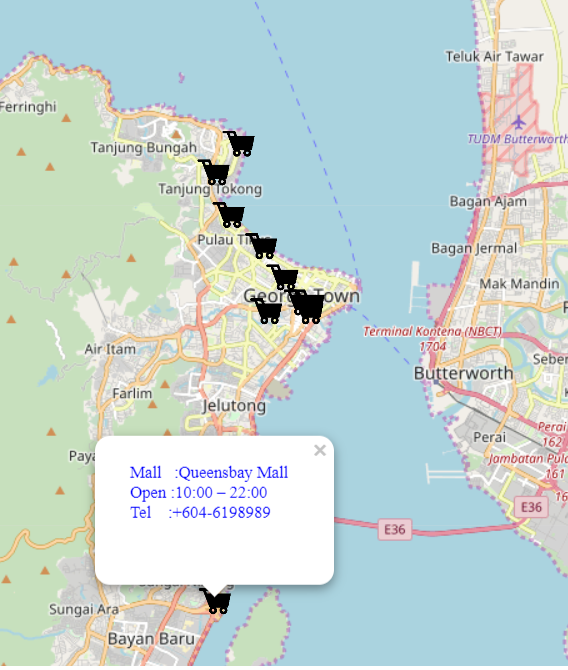

In [97]:
from IPython.display import Image
Image("Capture.png")